# Tucker Clustering

Run the next cell if these packages are not installed.

In [33]:
# ! pip install pyclustering
# ! pip install adjustText

## Imports

In [34]:
import pandas as pd
import numpy as np
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix

import os


In [35]:
# Define tensor labels
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]

# Load tensors
tensor_70 = np.load("real_data/tensor_70.npy")
tensor_100 = np.load("real_data/tensor_100.npy")
tensor_200 = np.load("real_data/tensor_200.npy")
tensor_300 = np.load("real_data/tensor_300.npy")

tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
ranks = [[2,2,3],[2,2,2],[2,2,2],[3,3,3]] # Found previously
# ranks = [[100,8,13],[100,11,11],[100,21,9],[100,31,6]] # Full rank

pat_list_70 = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

pat_list_100 =['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']

pat_list_200 = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']

pat_list_300 = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']


In [36]:
plt.rcParams.update({
    "font.size": 15,       # Default text size
    "axes.titlesize": 17,  # Title size
    "axes.labelsize": 15,  # X and Y label size
    "xtick.labelsize": 12, # X tick labels
    "ytick.labelsize": 13, # Y tick labels
    "legend.fontsize": 15,  # Legend text size
    "lines.linewidth": 3  # Increase line thickness
})

In [37]:
def save_figure(file_prefix,foldername=None):
    current_path = os.getcwd()
    if foldername==None:
        save_folder = os.path.join(current_path, f'Results/Tucker Clustering')
    else:
        save_folder = os.path.join(current_path, f'Results/Tucker Clustering/{foldername}')
    os.makedirs(save_folder, exist_ok=True)
    png_path = os.path.join(save_folder, f"{file_prefix}.png")
    pdf_path = os.path.join(save_folder, f"{file_prefix}.pdf")
    plt.savefig(png_path, bbox_inches='tight')
    plt.savefig(pdf_path, bbox_inches='tight')


## Clustering

### Apply Tucker


In [38]:
def Tucker_decomp(tensor, rank):
    core, factors = tucker(tensor, rank)
    return core, factors

In [39]:
# Initialize dictionary to store results
tucker_results = {}

# Run decomposition and store results
for i, (tensor, rank,name) in enumerate(zip(tensors, ranks, tensor_names)):
    core, factors = Tucker_decomp(tensor, rank)
    tucker_results[f'{name}'] = {
        'core': core,
        'factors': factors
    }

### Choose dimensions to cluster and prepare data
We want to cluster patients so we will use `factors[2]` $ = U_p$.

In [40]:
def get_Up(results,tensor_name):
    patient_factors = results[tensor_name]['factors'][2]
    return patient_factors

def prepare_patient_data(factor_matrix, normalize=False):
    """
    Extract and optionally normalize the patient factor matrix.
    """
    if normalize:
        scaler = StandardScaler()
        factor_matrix = scaler.fit_transform(factor_matrix)
    return factor_matrix


### Apply Clustering with K-medoids

#### Define clustering method

In [41]:
def pyclustering_kmedoids(data, n_clusters):
    initial_medoids = list(np.random.choice(range(len(data)), n_clusters, replace=False))
    distance_matrix = calculate_distance_matrix(data)
    kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    clusters = kmedoids_instance.get_clusters()
    medoid_indices = kmedoids_instance.get_medoids()
    labels = np.empty(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters):
        labels[cluster_points] = cluster_idx

    return labels, medoid_indices


#### Clustering pipeline

##### Find number of clusters (k)
WCSD (Within-Cluster Sum of Distances) formula for K-medoids

The WCSD is calculated as:

$WCSD = \sum_{i=1}^{k} \sum_{x \in C_i} d(x, \text{medoid}_i)$

where:
- $k$ = number of clusters
- $C_i$ = set of points in cluster $i$
- $\text{medoid}_i$ = medoid (representative point) of cluster $i$
- $d(x, \text{medoid}_i)$ = distance between point $x$ and medoid $i$


In [42]:
def calculate_wcsd(data, labels, medoid_indices):
    """
    Calculate within-cluster sum of squares (WCSD) for K-medoids.
    
    Parameters:
        data (array): Data matrix (n_samples x n_features).
        labels (array): Cluster labels for each sample.
        medoid_indices (list): Indices of the medoids in the data.
    
    Returns:
        float: WCSD value.
    """
    distance_matrix = calculate_distance_matrix(data)
    wcsd = 0

    for cluster_id in np.unique(labels):
        cluster_points = np.where(labels == cluster_id)[0]
        medoid_idx = medoid_indices[cluster_id]
        wcsd += np.sum([distance_matrix[point][medoid_idx] for point in cluster_points])

    return wcsd


In [43]:
def plot_wcsd_elbow(results, tensor_key, foldername=None):
    cluster_numbers = [r['n_clusters'] for r in results]
    wcsd_values = [r['wcsd'] for r in results]
    
    # Detect elbow point using KneeLocator
    kneedle = KneeLocator(cluster_numbers, wcsd_values, curve='convex', direction='decreasing')
    elbow_cluster = kneedle.knee

    # Plot WCSD curve
    plt.figure(figsize=(5, 4))
    plt.plot(cluster_numbers, wcsd_values, marker='o', label='WCSD')

    # Add vertical line at elbow if found
    if elbow_cluster is not None:
        plt.axvline(x=elbow_cluster, color='red', linestyle='--', label=f'Elbow at k={elbow_cluster}')
        plt.scatter(elbow_cluster, kneedle.knee_y, color='red', s=100, zorder=5)

    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSD')
    # plt.title(f'Elbow Plot for {tensor_key}')
    plt.legend()

    save_figure(f'WCSD_{tensor_key}', foldername)
    plt.show()


##### Pairplot plotting function

In [44]:
def plot_pairplot_clusters(data, labels, patient_names, title='Pairplot Cluster Plot', foldername=None):
    df = pd.DataFrame(data, columns=[f'Comp_{i+1}' for i in range(data.shape[1])])
    df['Cluster'] = labels.astype(str)
    df['Patient'] = patient_names

    # Create the pairplot
    g = sns.pairplot(df, hue='Cluster', palette='tab10', diag_kind='auto',corner=True)

    # Loop over all scatter subplots (upper triangle + lower triangle)
    # for i in range(len(df.columns) - 2):
    #     for j in range(len(df.columns) - 2):
    #         if i != j:
    #             ax = g.axes[i, j]
    #             texts = []
    #             for k, row in df.iterrows():
    #                 texts.append(ax.text(row[f'Comp_{j+1}'], row[f'Comp_{i+1}'], row['Patient'],
    #                                      fontsize=8, color='black'))
    #             adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Loop over all scatter subplots (lower triangle only)
    # for i in range(len(df.columns) - 2):
    #     for j in range(i + 1):  # j runs only up to i
    #         if i != j:
    #             ax = g.axes[i, j]
    #             if ax is not None:
    #                 texts = []
    #                 for k, row in df.iterrows():
    #                     texts.append(ax.text(row[f'Comp_{j+1}'], row[f'Comp_{i+1}'], row['Patient'],
    #                                         fontsize=10, color='black'))
    #                 adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
                            
    
    # plt.suptitle(title, y=1.02)
    save_figure(f"pairplot_{title.split()[0]}_{title.split('=')[1].rstrip(')')}",foldername)

    plt.show()

In [45]:
def plot_metric_pair_clusters(k, x_idx, y_idx, labels, data, patient_names, tensor):
    """
    Plot a pair of components from a patient-mode matrix (e.g., from Tucker) with cluster labels.

    Parameters:
        k (int): Number of clusters (used for saving).
        x_idx (int): Index of component for x-axis (e.g., 0 for Comp_1).
        y_idx (int): Index of component for y-axis (e.g., 1 for Comp_2).
        labels (array-like): Cluster labels per patient (from K-Medoids).
        data (ndarray): Patient-mode matrix (shape: patients × components).
        patient_names (list): List of patient identifiers.
    """
    df = pd.DataFrame(data, columns=[f'Comp_{i+1}' for i in range(data.shape[1])])
    df['Cluster'] = labels
    df['Patient'] = patient_names

    x_col = f'Comp_{x_idx + 1}'
    y_col = f'Comp_{y_idx + 1}'

    fig = plt.figure(figsize=(5, 4))
    ax = sns.scatterplot(data=df, x=x_col, y=y_col, hue='Cluster', palette='tab10', s=70)

    texts = []
    for _, row in df.iterrows():
        texts.append(plt.text(row[x_col], row[y_col], str(row['Patient']), fontsize=13))

    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.legend(loc='best')
    save_figure(f"tensor{tensor}_{x_col}_vs_{y_col}_k{k}", foldername='Pair-specific')
    plt.show()


##### Complete clustering pipeline

In [46]:
def run_clustering_pipeline_on_tensor(results,tensor_key, patient_names, normalize=False, n_clusters=2, foldername=None):
    # Step 1: Get patient factor matrix
    patient_factors = get_Up(results, tensor_key)
    data_prepared = prepare_patient_data(patient_factors, normalize=normalize)

    # Step 2: Run pyclustering K-medoids
    labels, medoid_indices = pyclustering_kmedoids(data_prepared, n_clusters)
    
    # Step 3: Calculate WCSD
    wcsd = calculate_wcsd(data_prepared, labels, medoid_indices)
    print(f"{tensor_key} | k: {n_clusters} | WCSD: {wcsd:.3f}")

    # Step 4: Plot clusters
    plot_pairplot_clusters(data_prepared, labels, patient_names, title=f'{tensor_key} K-medoids (k={n_clusters})',foldername=foldername)

    
    return {
        'n_clusters': n_clusters,
        'labels': labels,
        'medoid_indices': medoid_indices,
        'wcsd': wcsd,
        'data_prepared': data_prepared 
    }



In [47]:
def finding_K(results,tensor_key,cluster_range,patient_names,normalize, foldername=None):
    kmed_results = []

    for n_clusters in cluster_range:
        result = run_clustering_pipeline_on_tensor(results, tensor_key, patient_names,
                                                normalize=normalize,
                                                n_clusters=n_clusters,
                                                foldername=foldername)
        kmed_results.append(result)

    plot_wcsd_elbow(kmed_results, tensor_key,foldername)
    return kmed_results


#### Run for all tensors

##### 70

tensor_70 | k: 1 | WCSD: 18.987


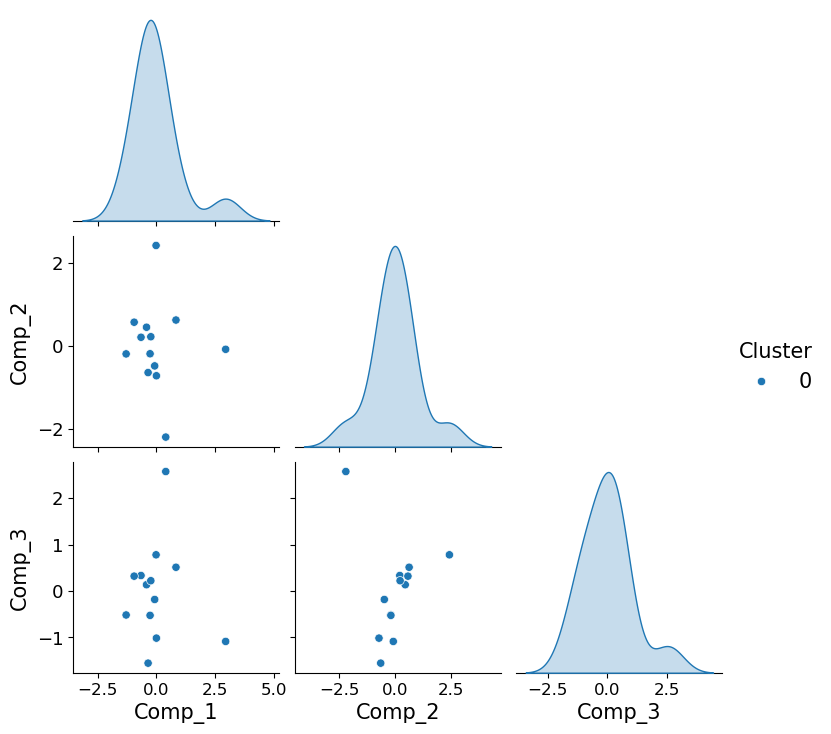

tensor_70 | k: 2 | WCSD: 15.066


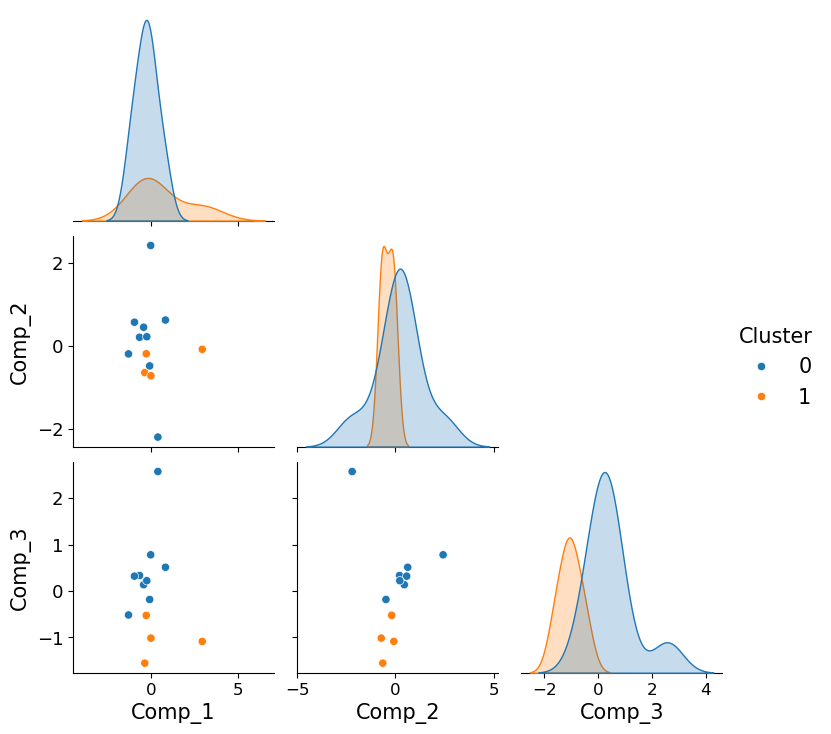

tensor_70 | k: 3 | WCSD: 11.394


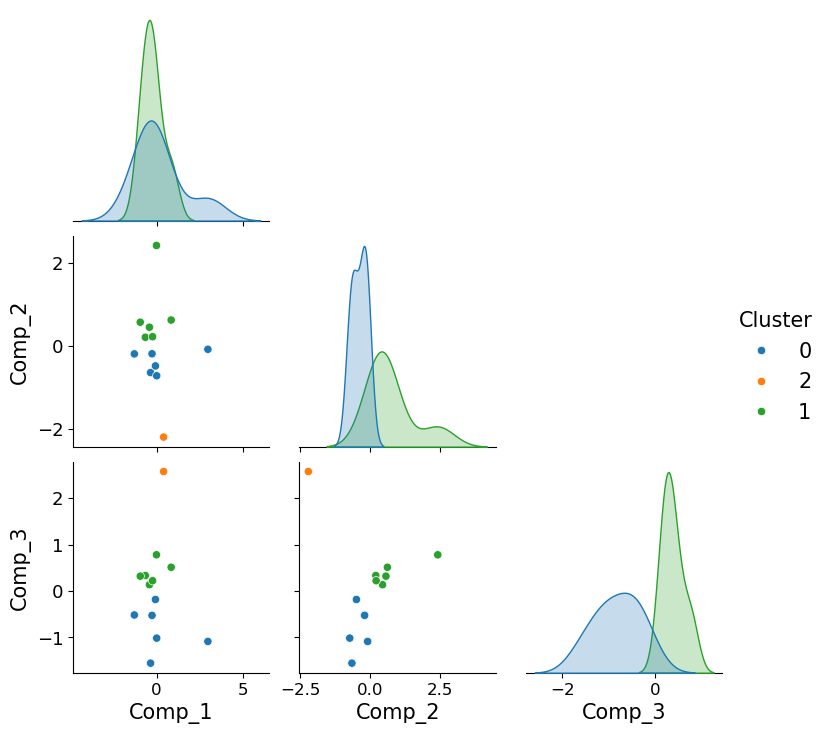

tensor_70 | k: 4 | WCSD: 8.264


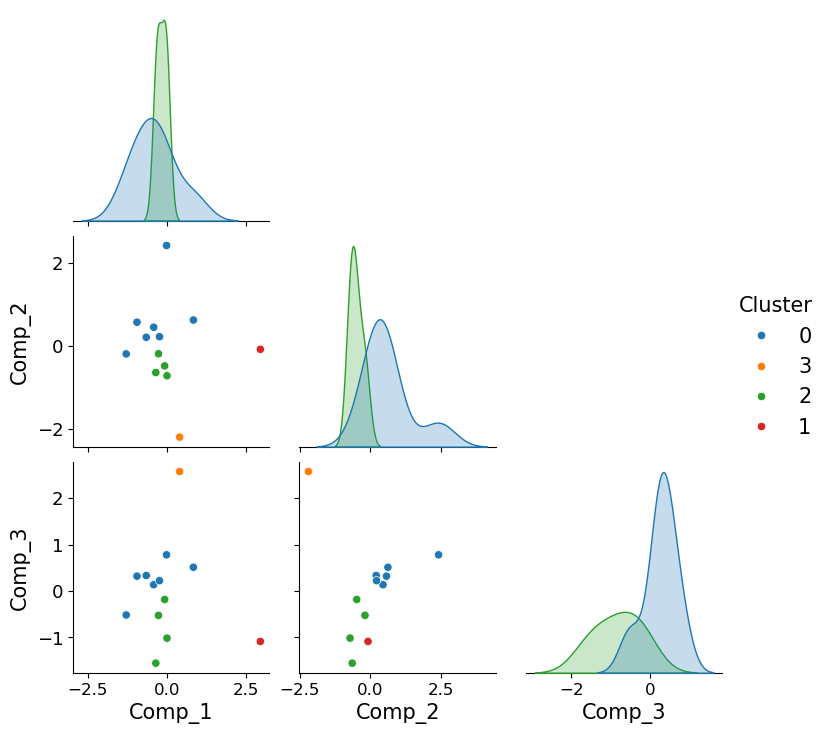

tensor_70 | k: 5 | WCSD: 6.133


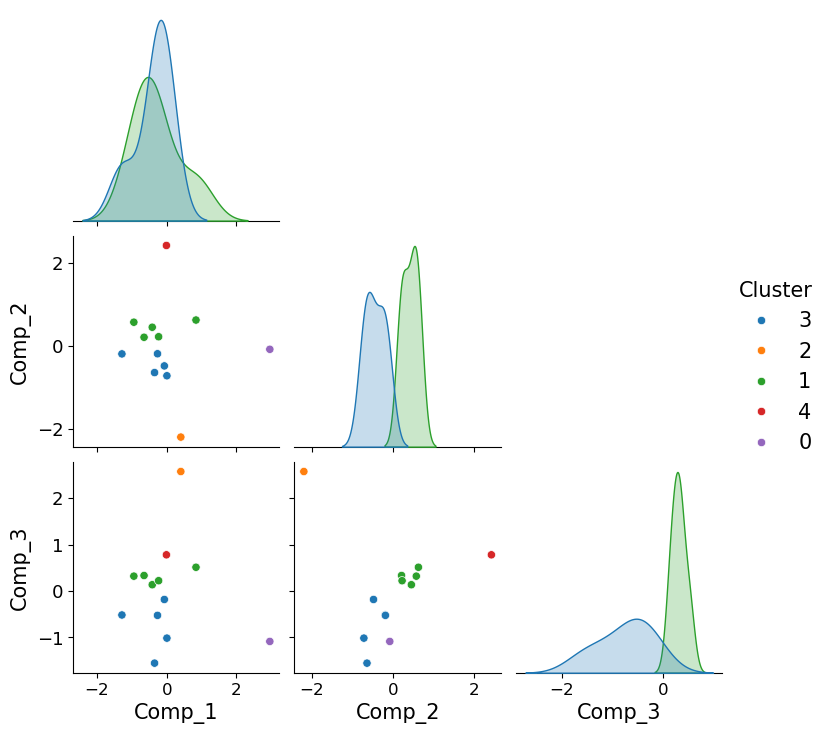

tensor_70 | k: 6 | WCSD: 4.706


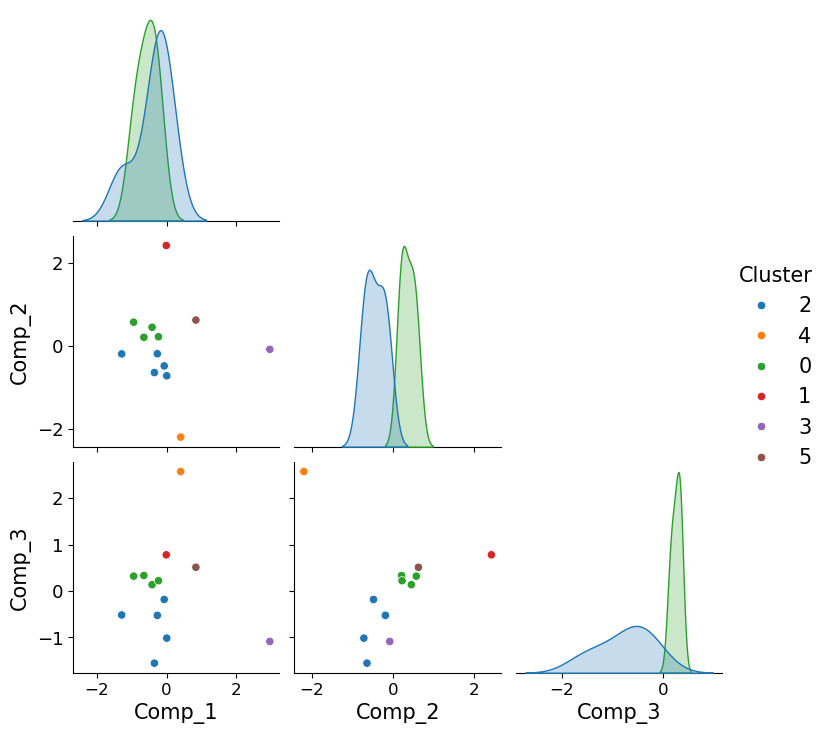

tensor_70 | k: 7 | WCSD: 3.432


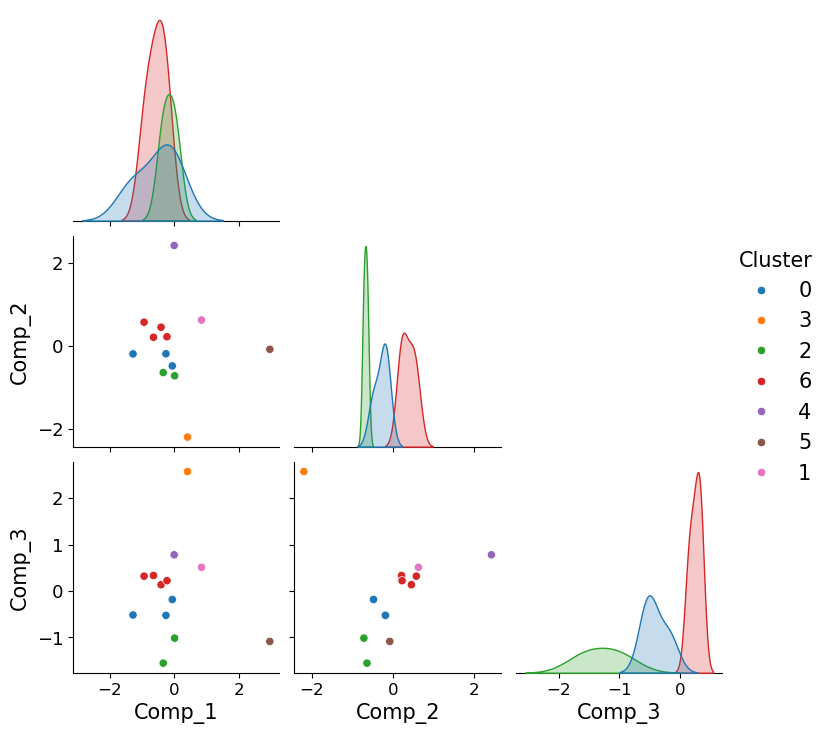

tensor_70 | k: 8 | WCSD: 2.412


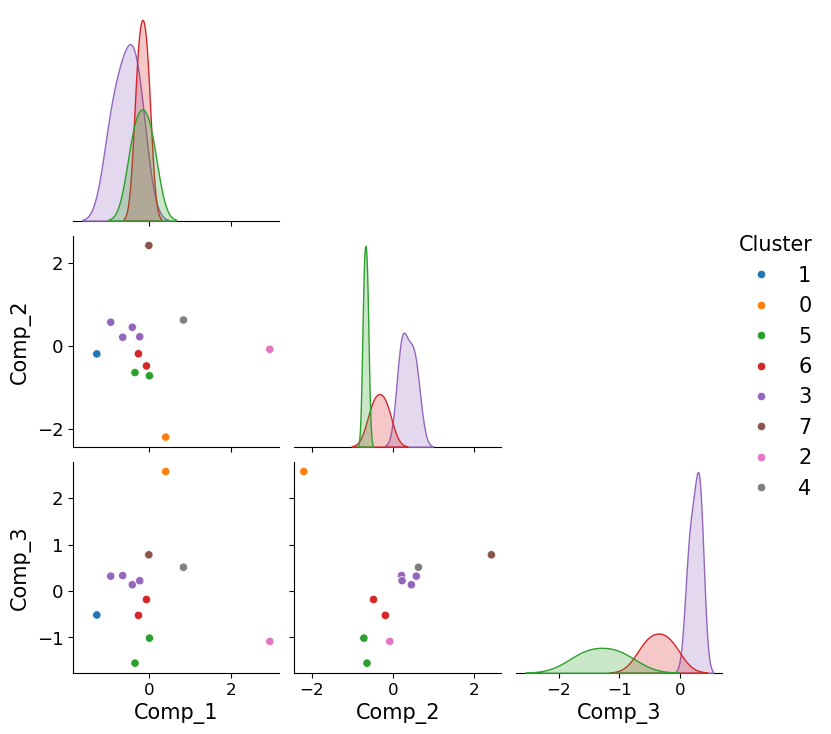

tensor_70 | k: 9 | WCSD: 1.762


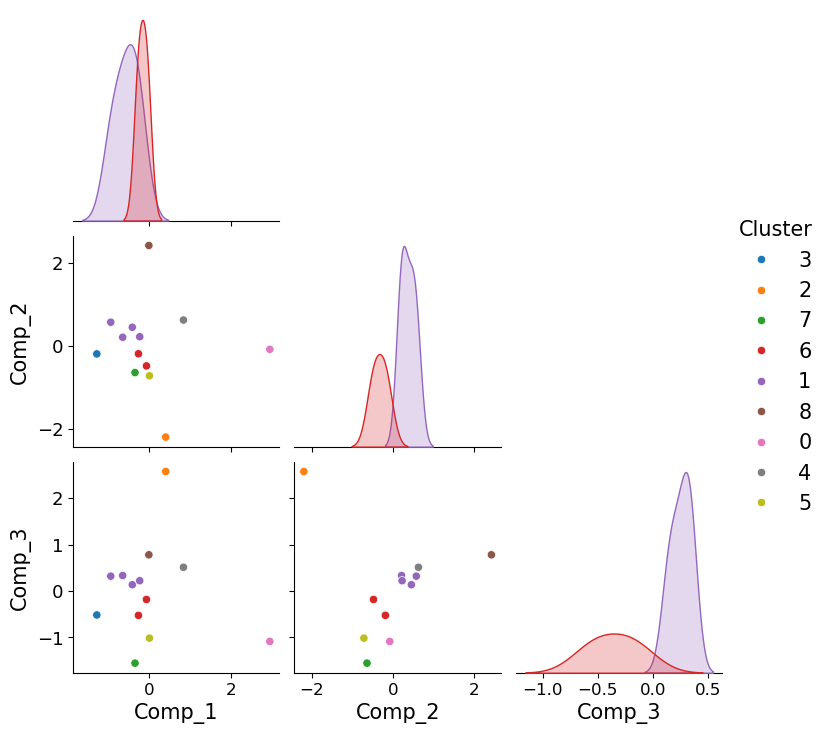

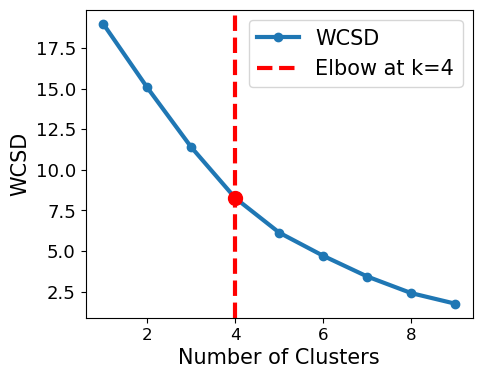

In [48]:
cluster_range = range(1, 10) # Maximum we guess 5 clusters
tensor_key = 'tensor_70'
patient_names = pat_list_70
normalize = True
# normalize=False

kmed_70_results = finding_K(tucker_results,tensor_key,cluster_range,patient_names,normalize,foldername='Real_data')


##### 100

tensor_100 | k: 1 | WCSD: 12.322


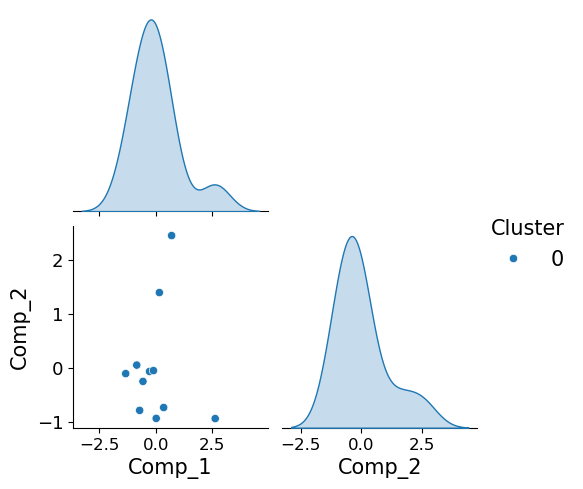

tensor_100 | k: 2 | WCSD: 9.007


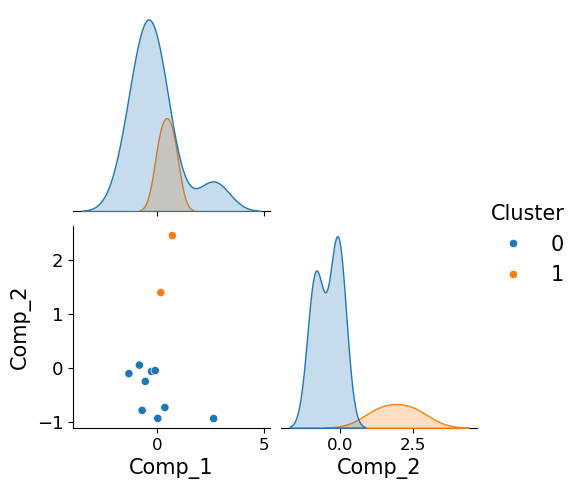

tensor_100 | k: 3 | WCSD: 5.730


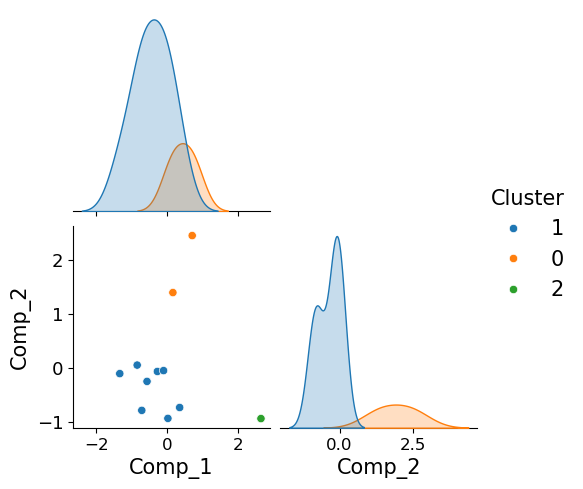

tensor_100 | k: 4 | WCSD: 4.176


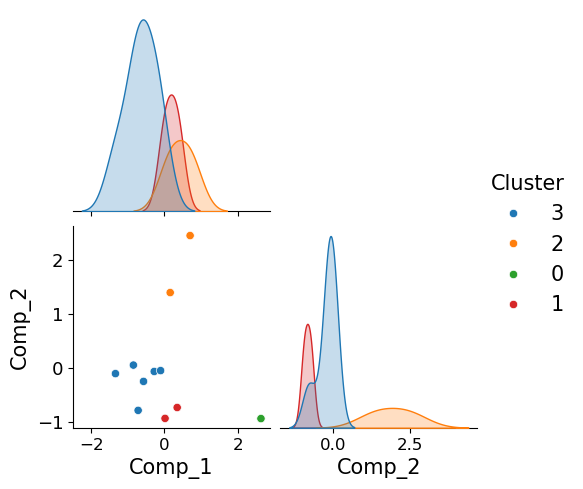

tensor_100 | k: 5 | WCSD: 2.987


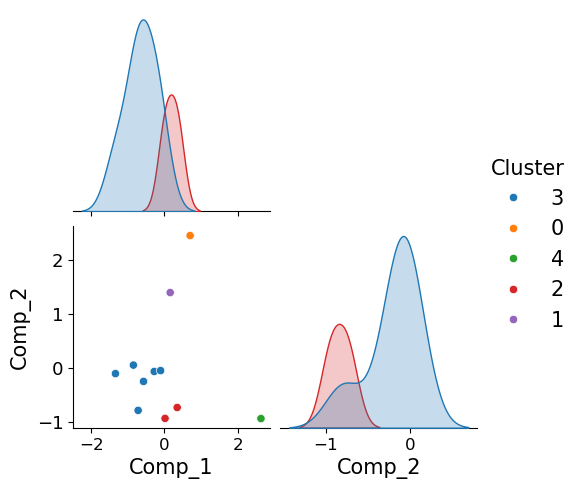

tensor_100 | k: 6 | WCSD: 2.207


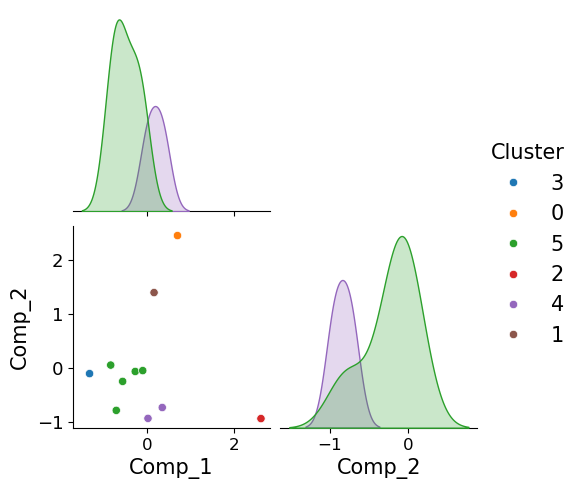

tensor_100 | k: 7 | WCSD: 1.421


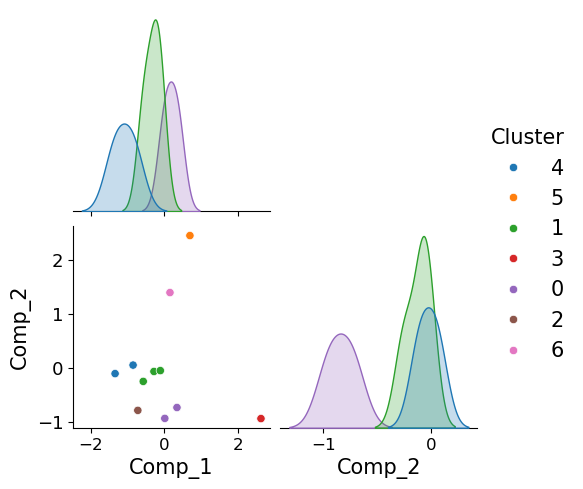

tensor_100 | k: 8 | WCSD: 0.907


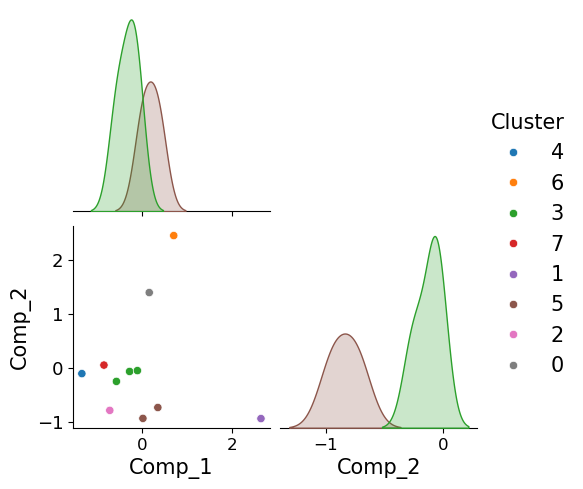

tensor_100 | k: 9 | WCSD: 0.562


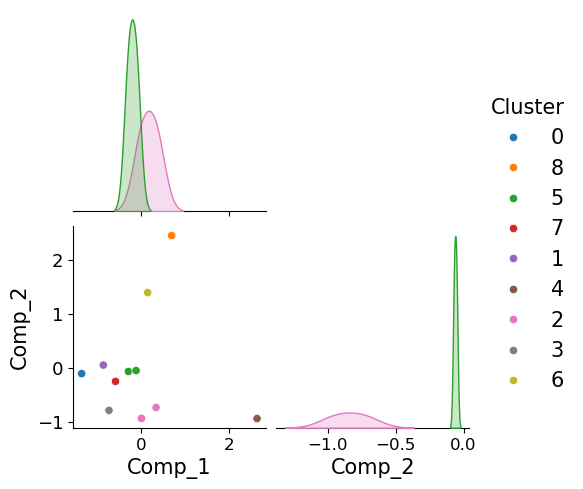

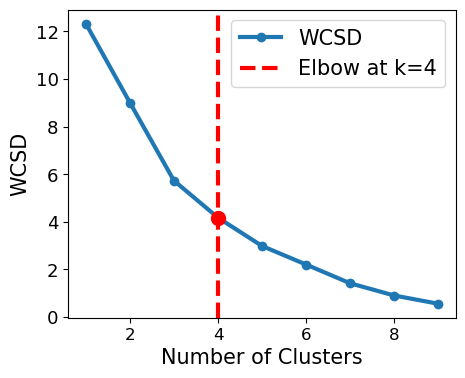

In [49]:
cluster_range = range(1, 10) # Maximum we guess 5 colusters
tensor_key = 'tensor_100'
patient_names = pat_list_100
# normalize=False
normalize = True

kmed_100_results = finding_K(tucker_results,tensor_key,cluster_range,patient_names,normalize,foldername='Real_data')

##### 200

tensor_200 | k: 1 | WCSD: 8.812


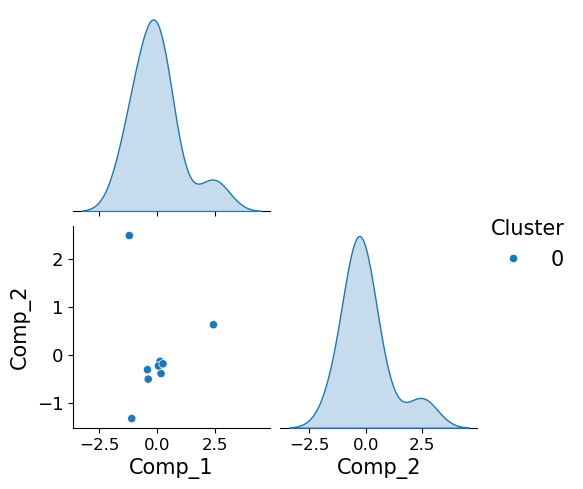

tensor_200 | k: 2 | WCSD: 5.867


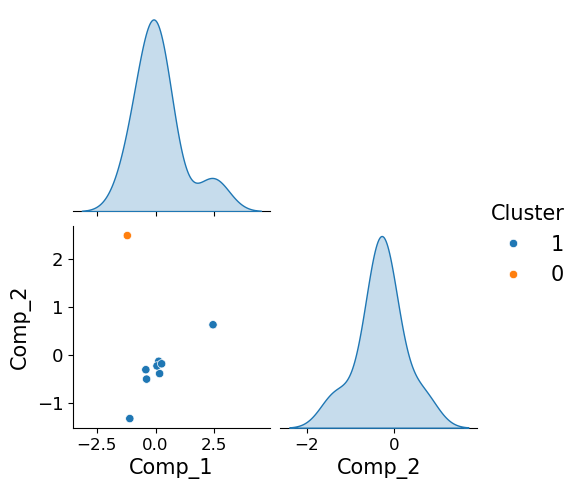

tensor_200 | k: 3 | WCSD: 3.408


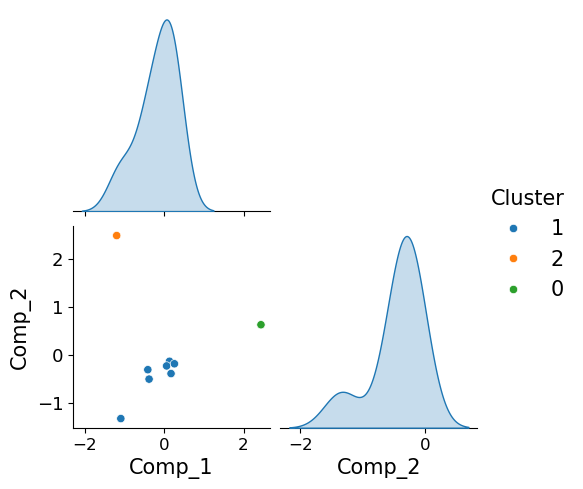

tensor_200 | k: 4 | WCSD: 1.726


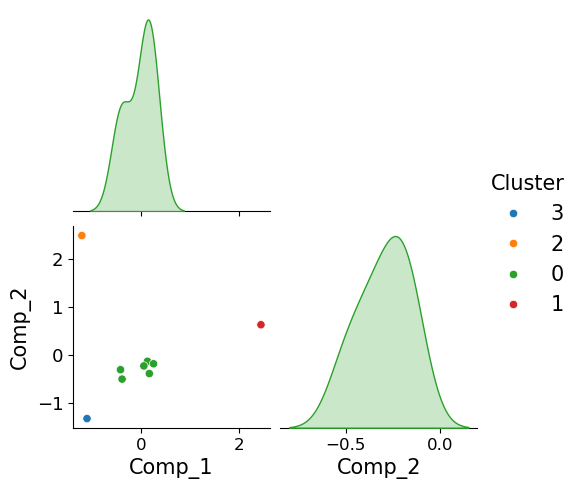

tensor_200 | k: 5 | WCSD: 0.715


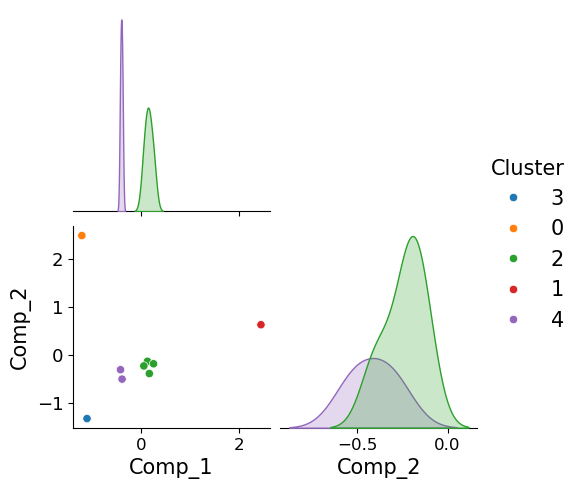

tensor_200 | k: 6 | WCSD: 0.516


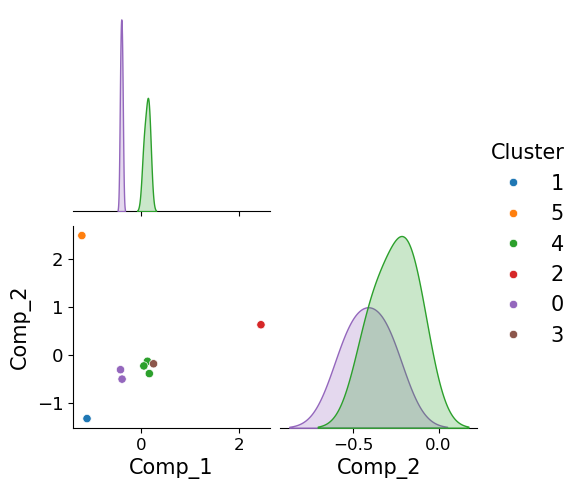

tensor_200 | k: 7 | WCSD: 0.321


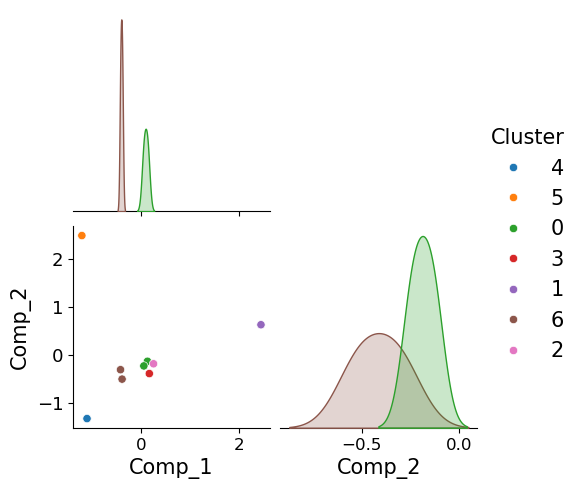

tensor_200 | k: 8 | WCSD: 0.122


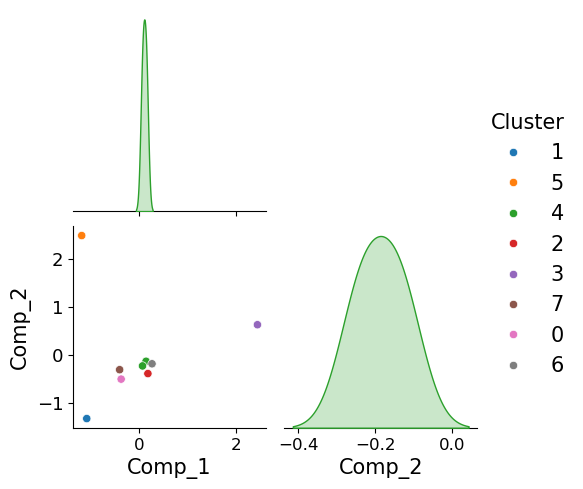

tensor_200 | k: 9 | WCSD: 0.000


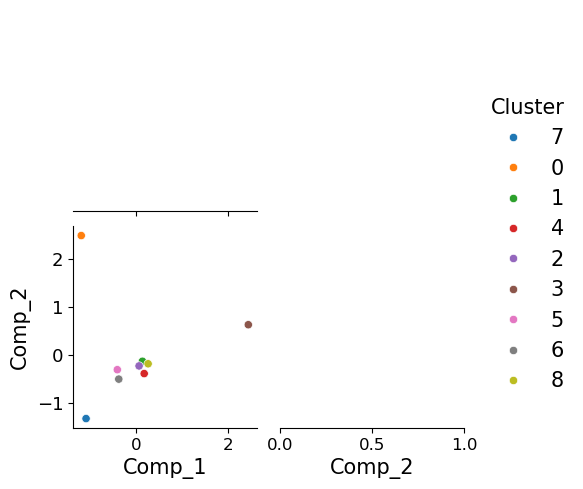

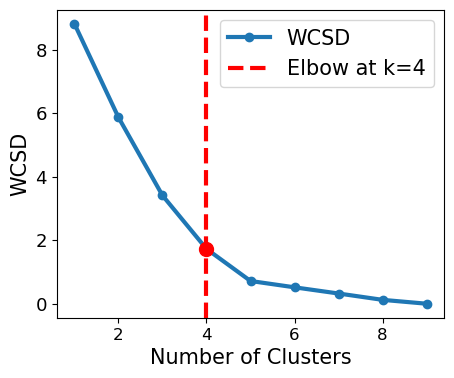

In [50]:
cluster_range = range(1, 10) # Maximum we guess 5 colusters
tensor_key = 'tensor_200'
patient_names = pat_list_200
normalize = True

kmed_200_results = finding_K(tucker_results, tensor_key,cluster_range,patient_names,normalize,foldername='Real_data')

##### 300

tensor_300 | k: 1 | WCSD: 9.719


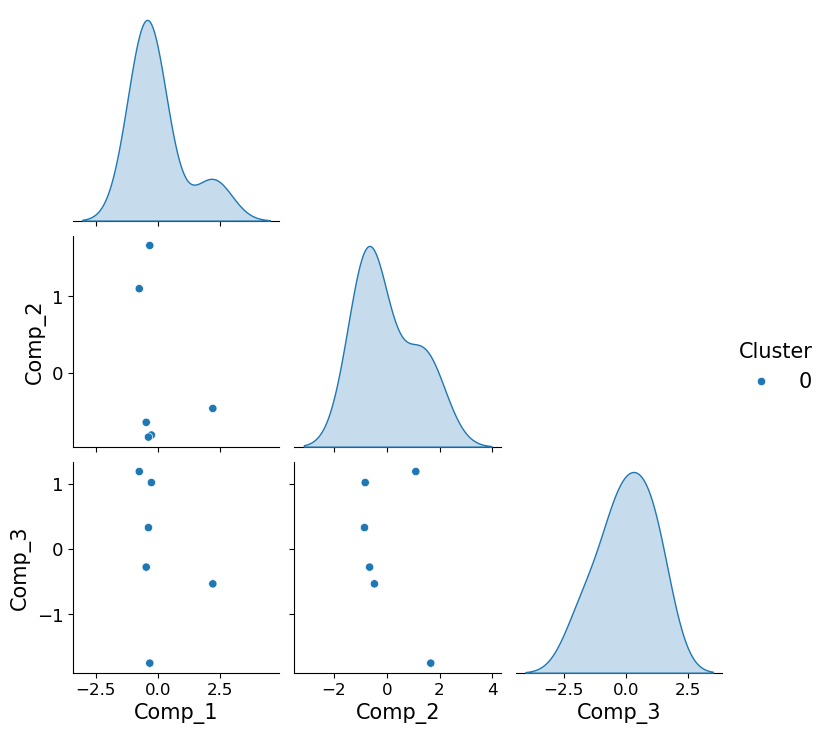

tensor_300 | k: 2 | WCSD: 6.762


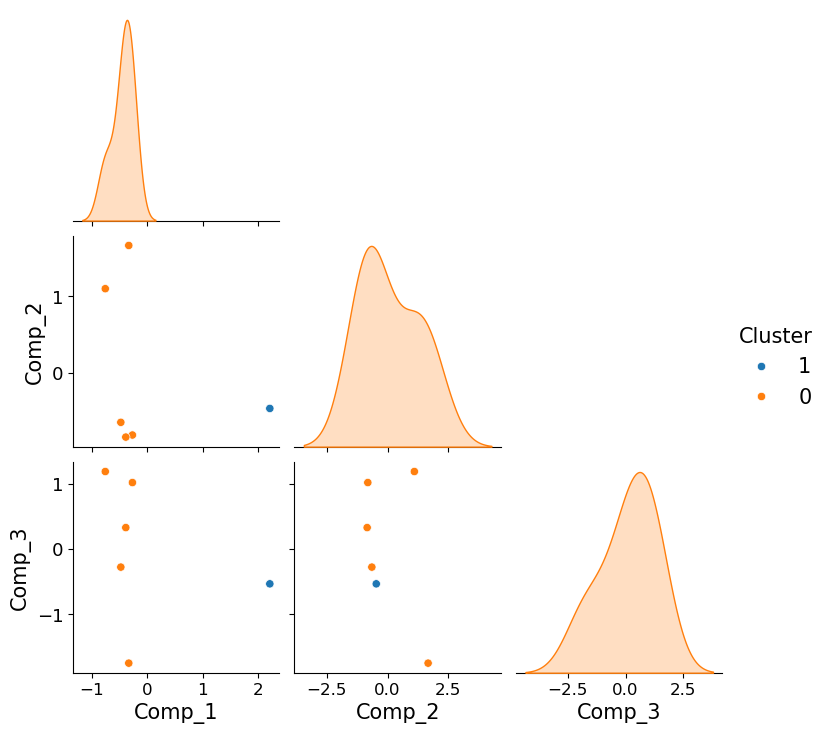

tensor_300 | k: 3 | WCSD: 4.012


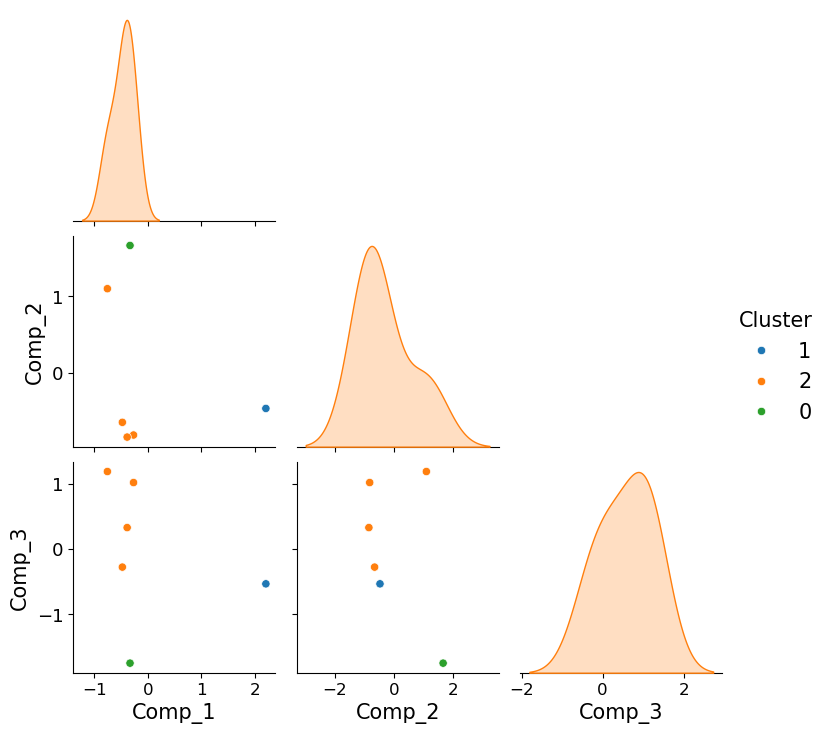

tensor_300 | k: 4 | WCSD: 1.969


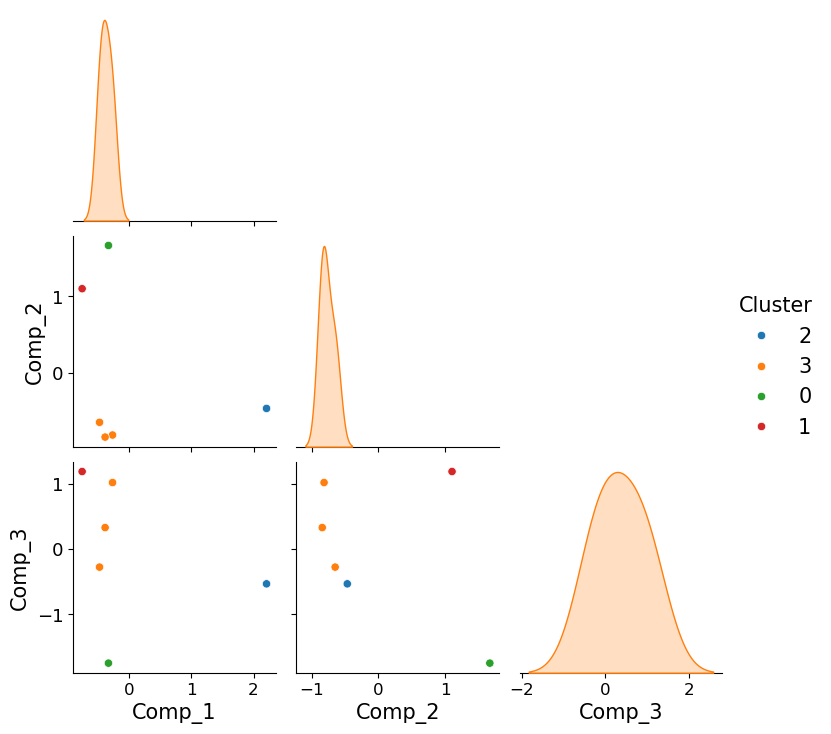

tensor_300 | k: 5 | WCSD: 0.643


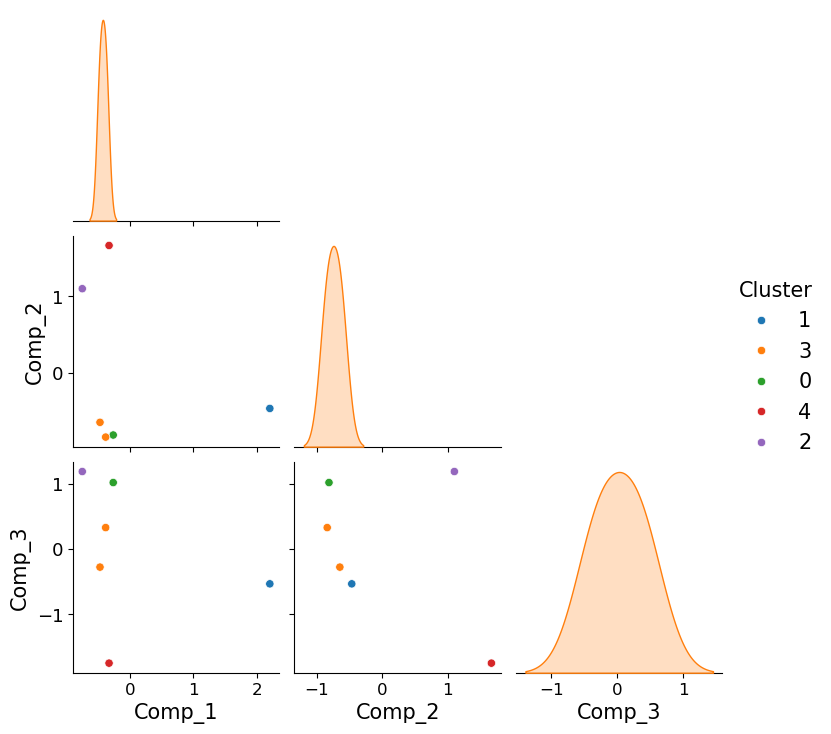

tensor_300 | k: 6 | WCSD: 0.000


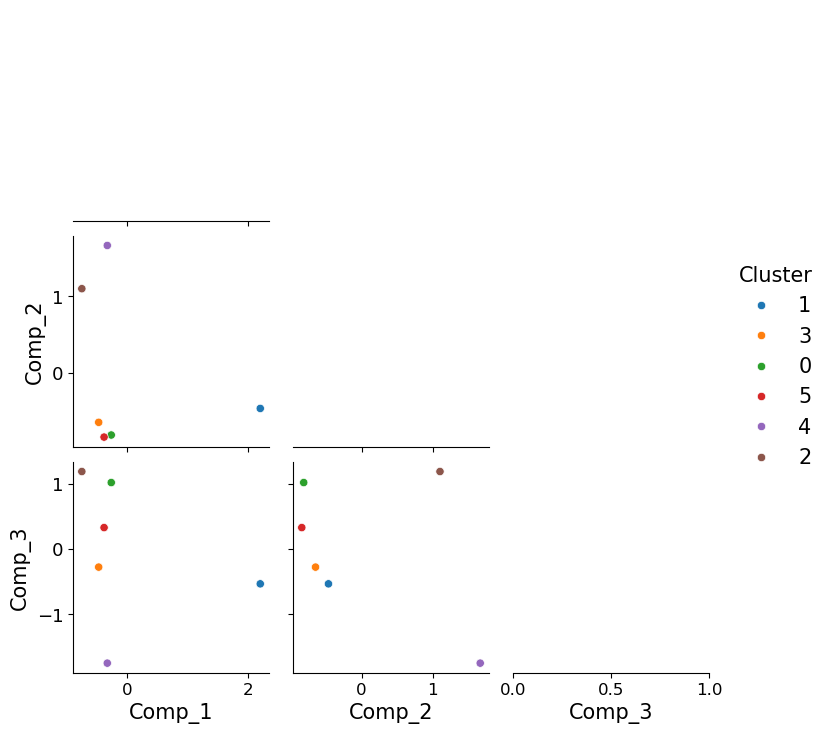

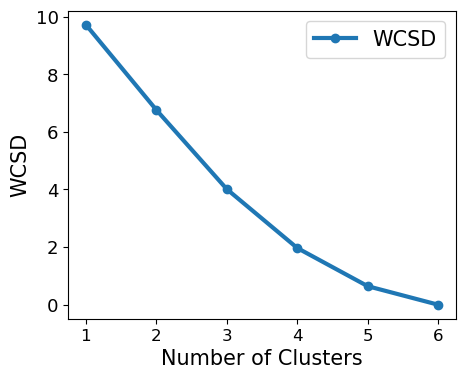

In [51]:
cluster_range = range(1, 7) # Maximum we guess 5 colusters
tensor_key = 'tensor_300'
patient_names = pat_list_300
normalize = True

kmed_300_results = finding_K(tucker_results, tensor_key,cluster_range,patient_names,normalize,foldername='Real_data')

#### K evaluation

In [52]:
def plot_all_wcsd(all_results, foldername=None):
    plt.figure(figsize=(6, 4))

    # Get color cycle from matplotlib
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, (tensor_key, results) in enumerate(all_results.items()):
        cluster_numbers = [r['n_clusters'] for r in results]
        wcsd_values = [r['wcsd'] for r in results]
        color = color_cycle[i % len(color_cycle)]

        # Plot WCSD line with consistent styling
        plt.plot(cluster_numbers, wcsd_values, marker='.', markersize=5,
                 linewidth=2, label=tensor_key, color=color)

        # Add elbow marker
        knee = KneeLocator(cluster_numbers, wcsd_values, curve='convex', direction='decreasing')
        if knee.elbow:
            elbow_x = knee.elbow
            elbow_y = wcsd_values[cluster_numbers.index(elbow_x)]
            plt.plot(elbow_x, elbow_y, 'X', markersize=15, color=color, markeredgecolor='black')

    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSD')
    plt.legend(loc='best')
    plt.tight_layout()
    save_figure("All_WCSD", foldername)
    plt.show()


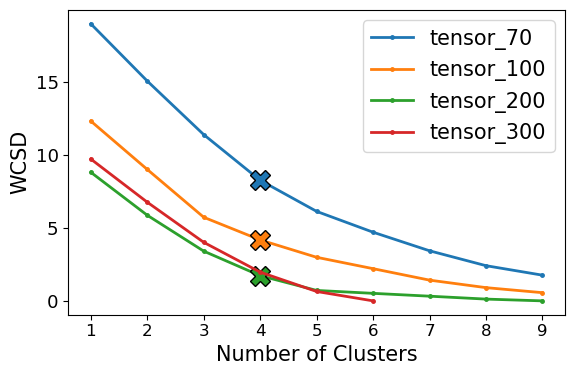

In [53]:
# Combine your results into one dictionary
all_results = {
    'tensor_70': kmed_70_results,
    'tensor_100': kmed_100_results,
    'tensor_200': kmed_200_results,
    'tensor_300': kmed_300_results
}

plot_all_wcsd(all_results,foldername='Real_data')

#### Component-pair plotting
Next we plot specific pair of components for the most optimal number of clusters for better visibility.

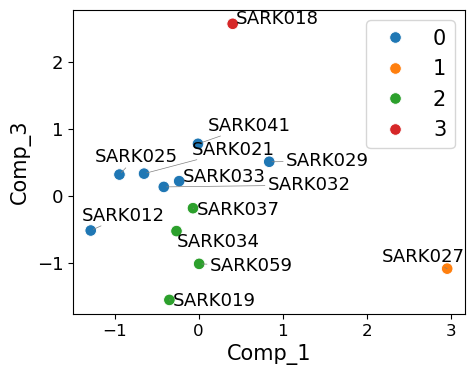

In [54]:
# FOR TENSOR_70
k=4 #Number of clusters we want to plot
result = kmed_70_results[k-1] # Equal to n_clusters=4, to account indexing
patient_names = pat_list_70

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=2,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='70'
)

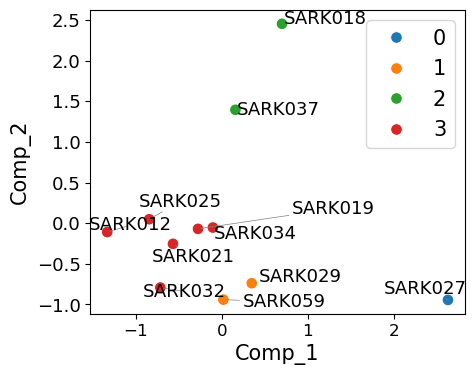

In [55]:
# FOR TENSOR_100
k=4 #Number of clusters we want to plot
result = kmed_100_results[k-1] # Equal to n_clusters=4, to account indexing
patient_names = pat_list_100

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=1,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='100'
)

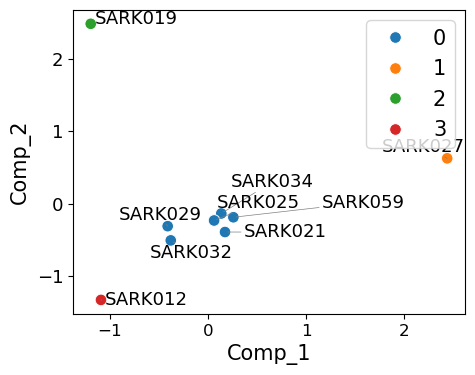

In [56]:
# FOR TENSOR_200
k=4 #Number of clusters we want to plot
result = kmed_200_results[k-1] # Equal to n_clusters=4, to account indexing
patient_names = pat_list_200

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=1,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='200'
)

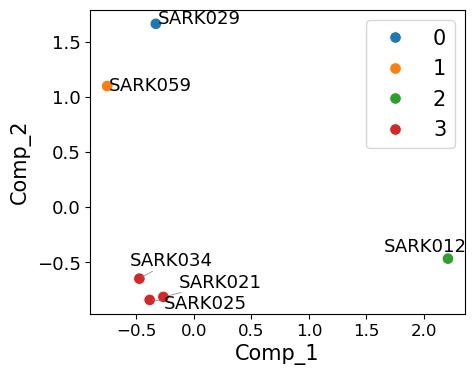

In [57]:
# FOR TENSOR_300
k=4 #Number of clusters we want to plot
result = kmed_300_results[k-1] # Equal to n_clusters=4, to account indexing
patient_names = pat_list_300

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=1,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='300'
)

## Save results for cluster comparison

In [58]:
# For tensor_70
for n_clusters in range(1,10):
    k_tucker = n_clusters
    tucker_result = next(r for r in kmed_70_results if r['n_clusters'] == k_tucker)

    # Match patient names and save
    tucker_labels_df = pd.DataFrame({
        'patient': pat_list_70,  # must match order of clustering
        'cluster': tucker_result['labels']
    })
    tucker_labels_df.to_csv(f'Clust_Results/labels_Tucker_tensor_70_k{k_tucker}.csv', index=False)

# For tensor_100
for n_clusters in range(1,10):
    k_tucker = n_clusters
    tucker_result = next(r for r in kmed_100_results if r['n_clusters'] == k_tucker)

    # Match patient names and save
    tucker_labels_df = pd.DataFrame({
        'patient': pat_list_100,  # must match order of clustering
        'cluster': tucker_result['labels']
    })
    tucker_labels_df.to_csv(f'Clust_Results/labels_Tucker_tensor_100_k{k_tucker}.csv', index=False)

# For tensor_200
for n_clusters in range(1,10):
    k_tucker = n_clusters
    tucker_result = next(r for r in kmed_200_results if r['n_clusters'] == k_tucker)

    # Match patient names and save
    tucker_labels_df = pd.DataFrame({
        'patient': pat_list_200,  # must match order of clustering
        'cluster': tucker_result['labels']
    })
    tucker_labels_df.to_csv(f'Clust_Results/labels_Tucker_tensor_200_k{k_tucker}.csv', index=False)

# For tensor_300
for n_clusters in range(1,7):
    k_tucker = n_clusters
    tucker_result = next(r for r in kmed_300_results if r['n_clusters'] == k_tucker)

    # Match patient names and save
    tucker_labels_df = pd.DataFrame({
        'patient': pat_list_300,  # must match order of clustering
        'cluster': tucker_result['labels']
    })
    tucker_labels_df.to_csv(f'Clust_Results/labels_Tucker_tensor_300_k{k_tucker}.csv', index=False)


# Simulated data

In [59]:
# Load tensors
tensor_1 = np.load("simulated_data/tensor_1.npy")
tensor_2 = np.load("simulated_data/tensor_2.npy")

ranks = [[3,2,3],[2,2,3]] # Found previously

# Apply Tucker
core1, factors1 = tucker(tensor_1, ranks[0])
core2, factors2 = tucker(tensor_2, ranks[1])
sim_results = {}
sim_results['tensor_1'] = {'core': core1,'factors': factors1}
sim_results['tensor_2'] = {'core': core2,'factors': factors2}


## tensor_1

tensor_1 | k: 1 | WCSD: 18.182


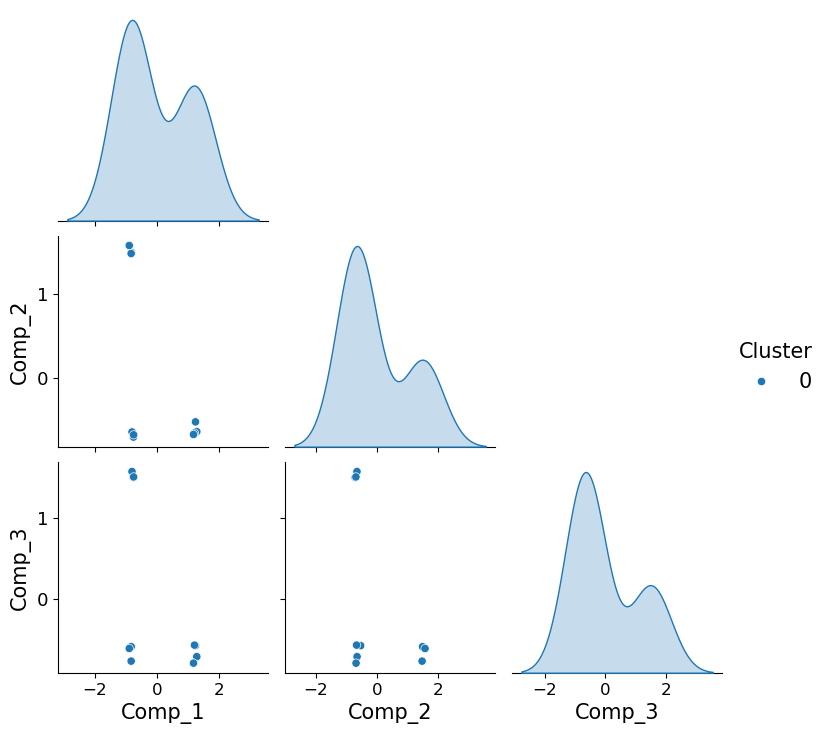

tensor_1 | k: 2 | WCSD: 9.451


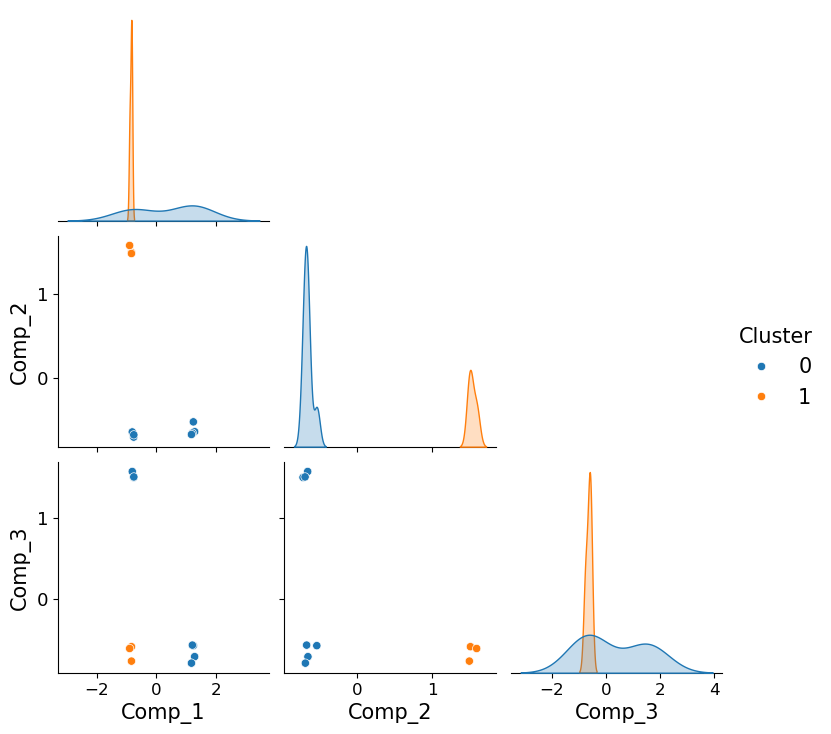

tensor_1 | k: 3 | WCSD: 0.900


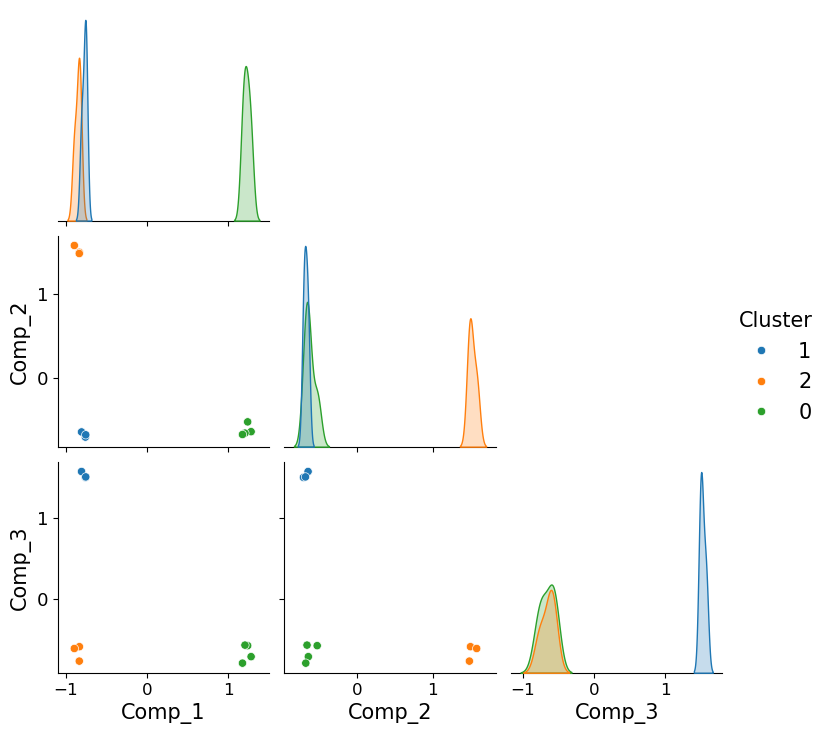

tensor_1 | k: 4 | WCSD: 0.679


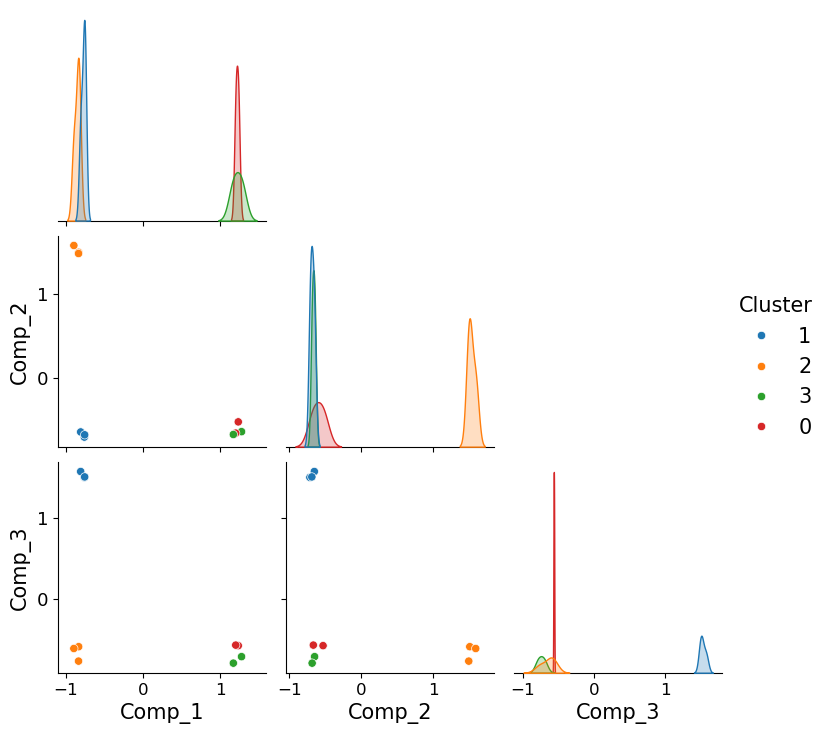

tensor_1 | k: 5 | WCSD: 0.501


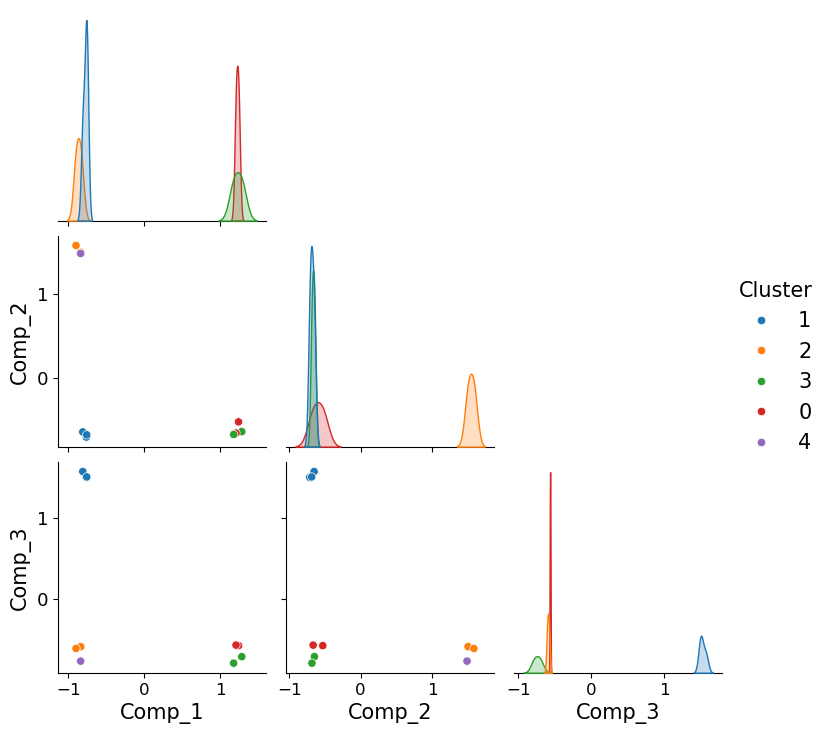

tensor_1 | k: 6 | WCSD: 0.362


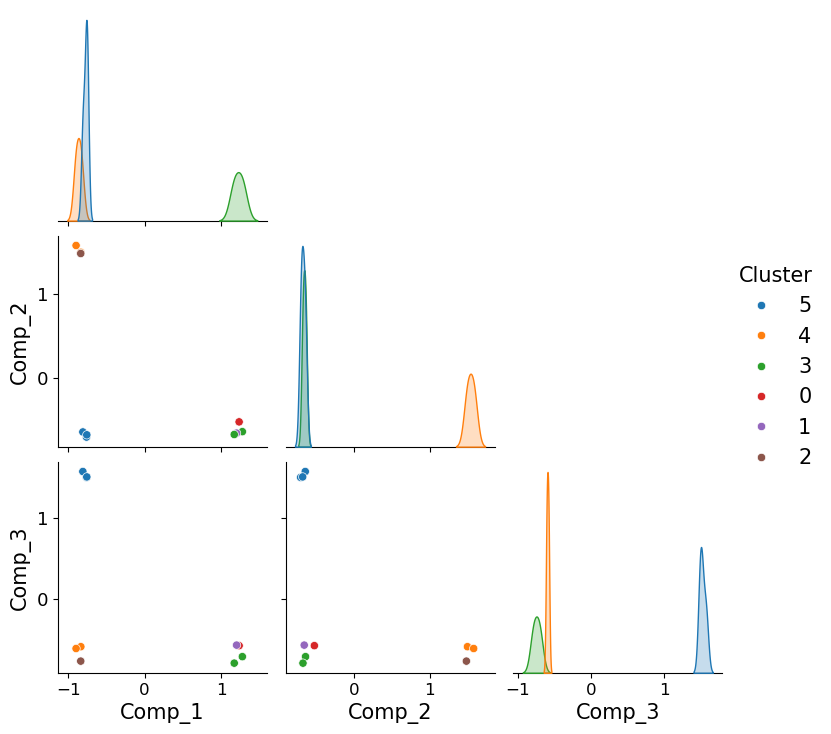

tensor_1 | k: 7 | WCSD: 0.225


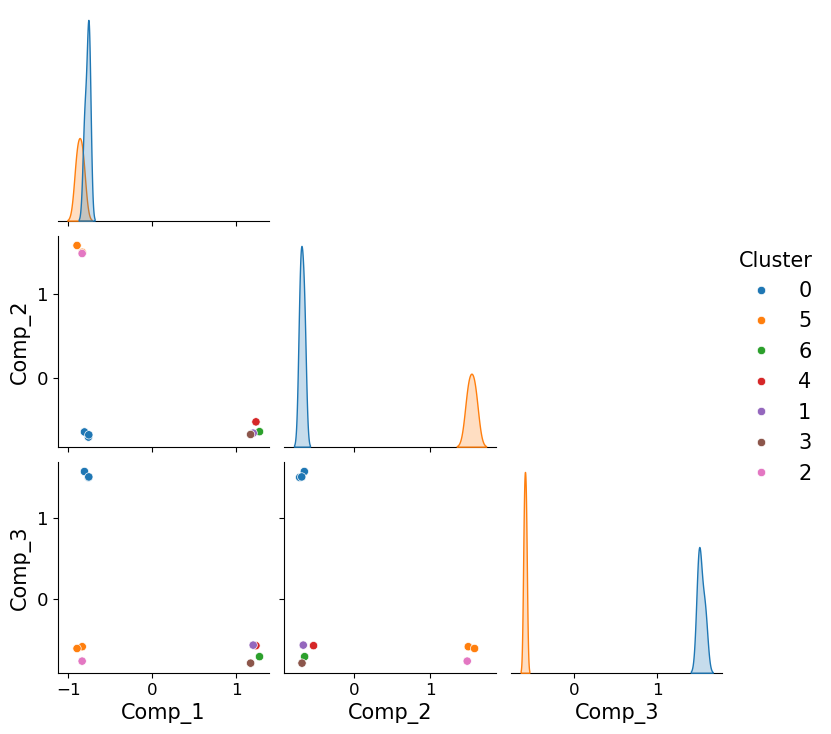

tensor_1 | k: 8 | WCSD: 0.134


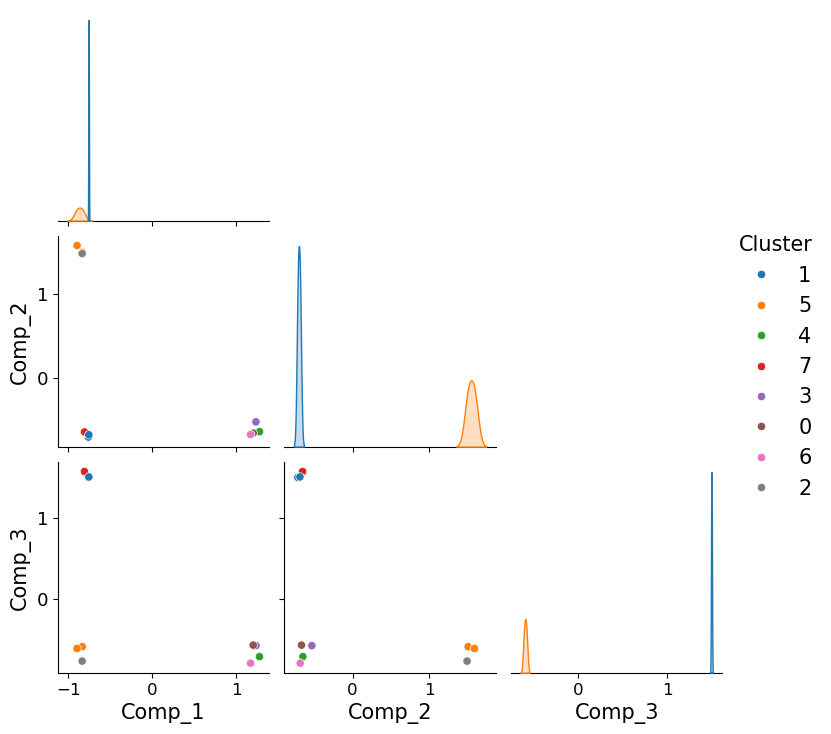

tensor_1 | k: 9 | WCSD: 0.028


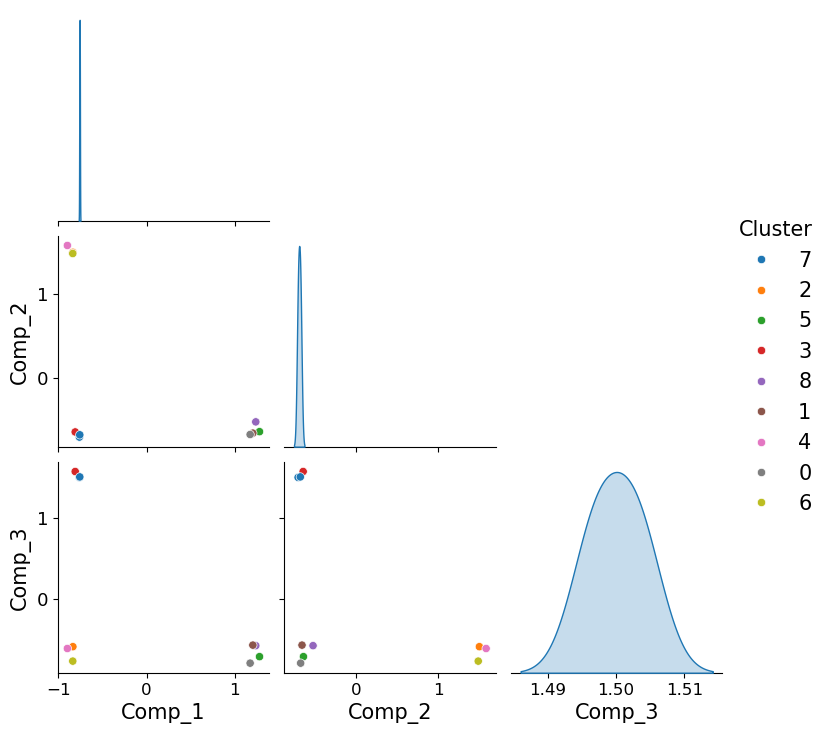

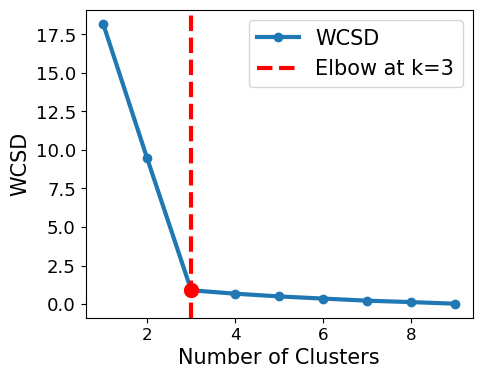

In [60]:
cluster_range = range(1, 10) # Maximum we guess 5 clusters
tensor_key = 'tensor_1'
patient_names = [f'{i}' for i in range(1, 11)]
normalize = True
# normalize=False

kmed_1_results = finding_K(sim_results, tensor_key,cluster_range,patient_names,normalize,foldername='Sim_data')



## tensor_2

tensor_2 | k: 1 | WCSD: 18.344


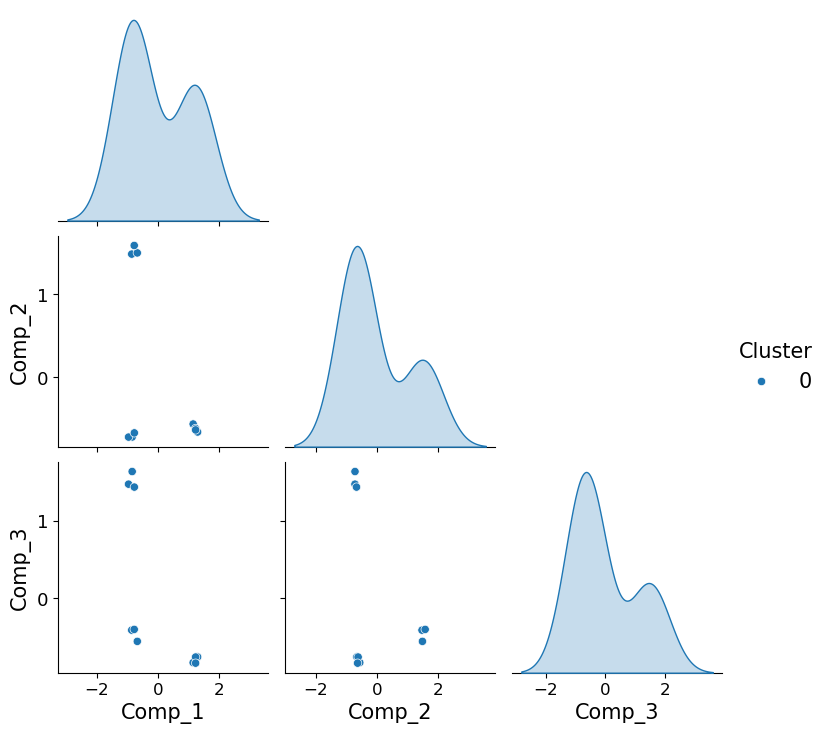

tensor_2 | k: 2 | WCSD: 9.323


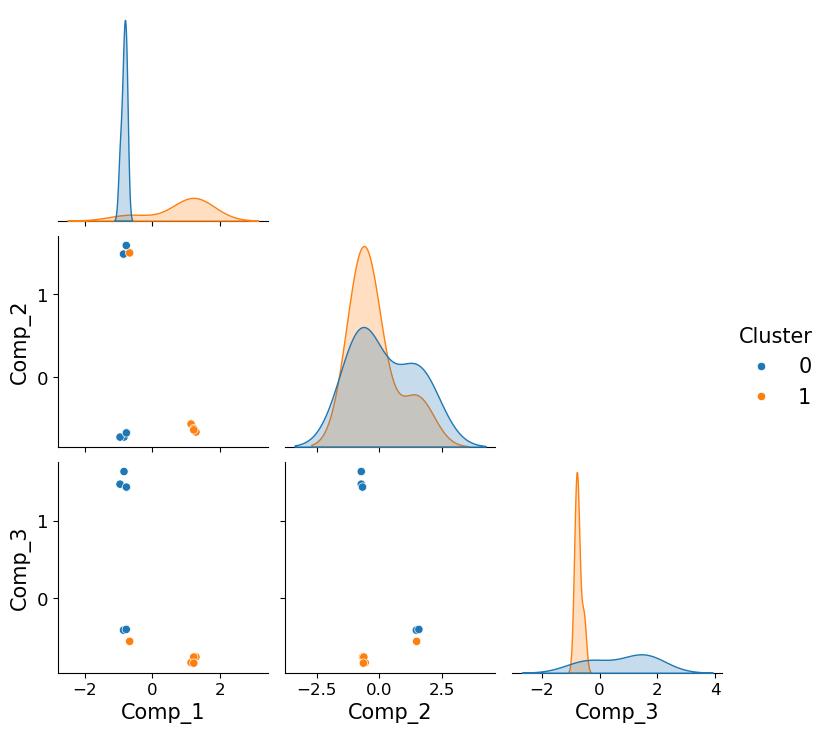

tensor_2 | k: 3 | WCSD: 1.031


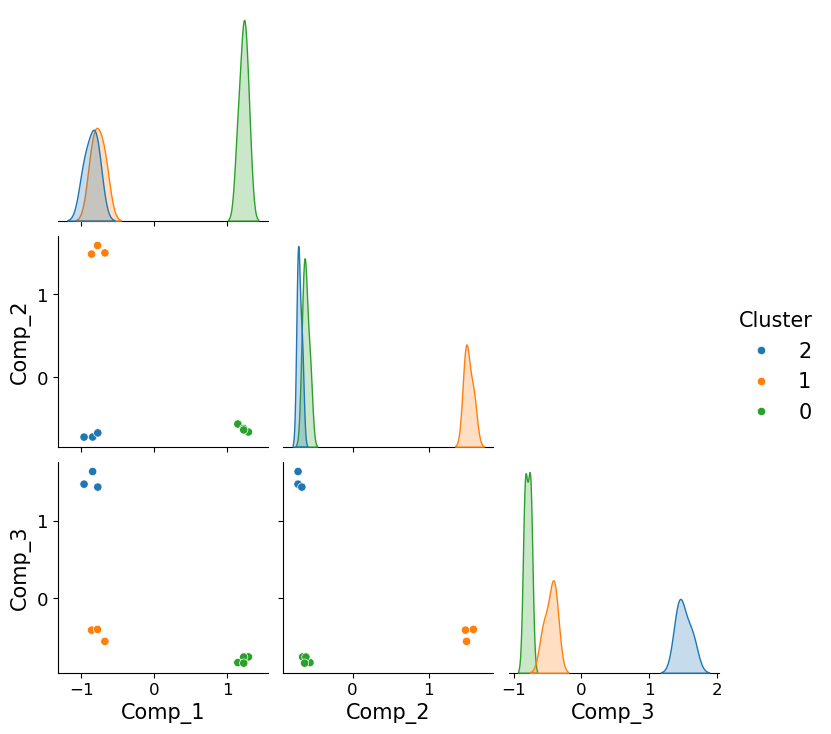

tensor_2 | k: 4 | WCSD: 0.810


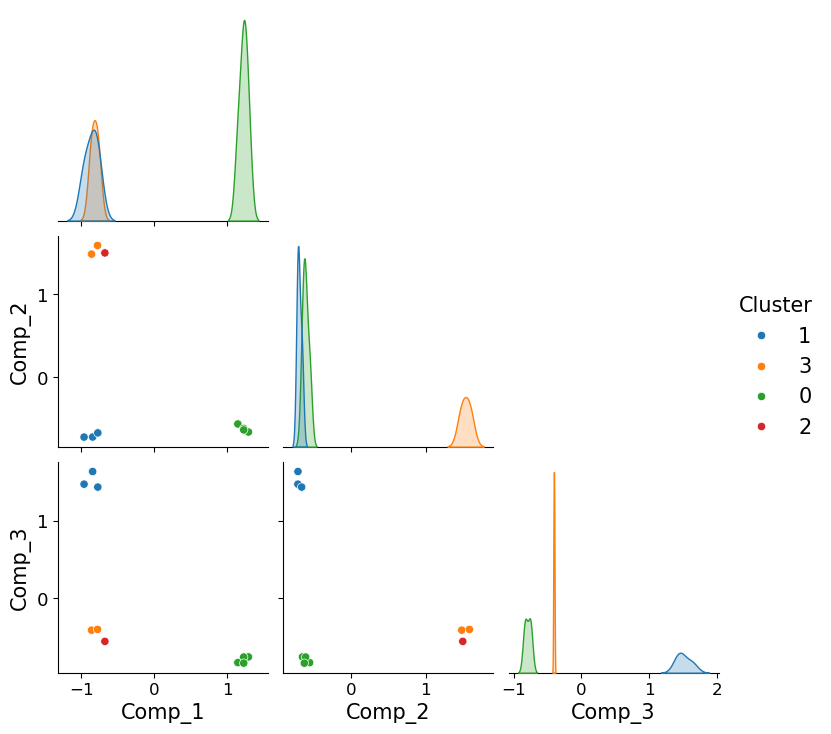

tensor_2 | k: 5 | WCSD: 0.610


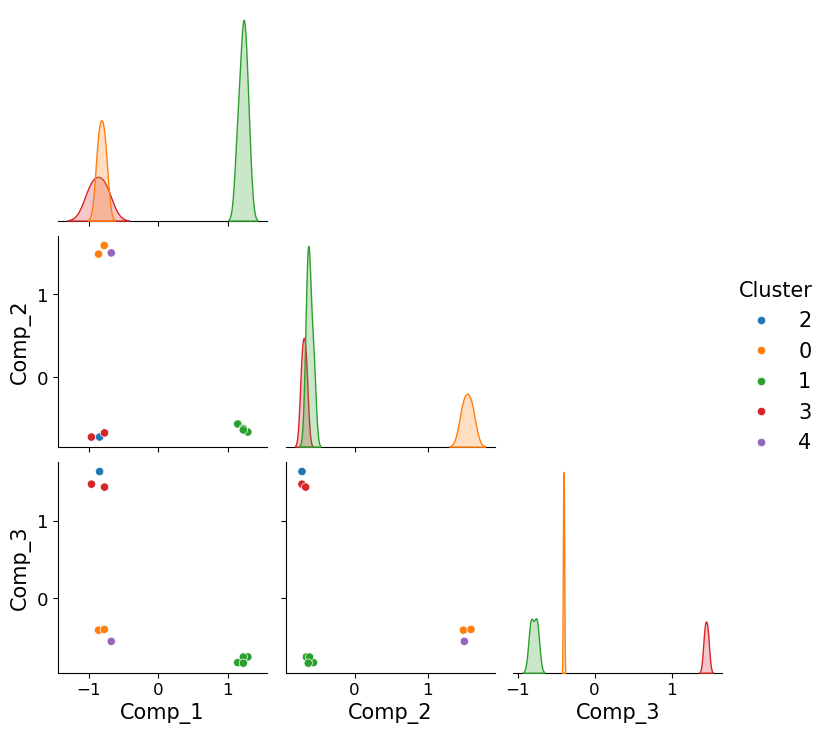

tensor_2 | k: 6 | WCSD: 0.411


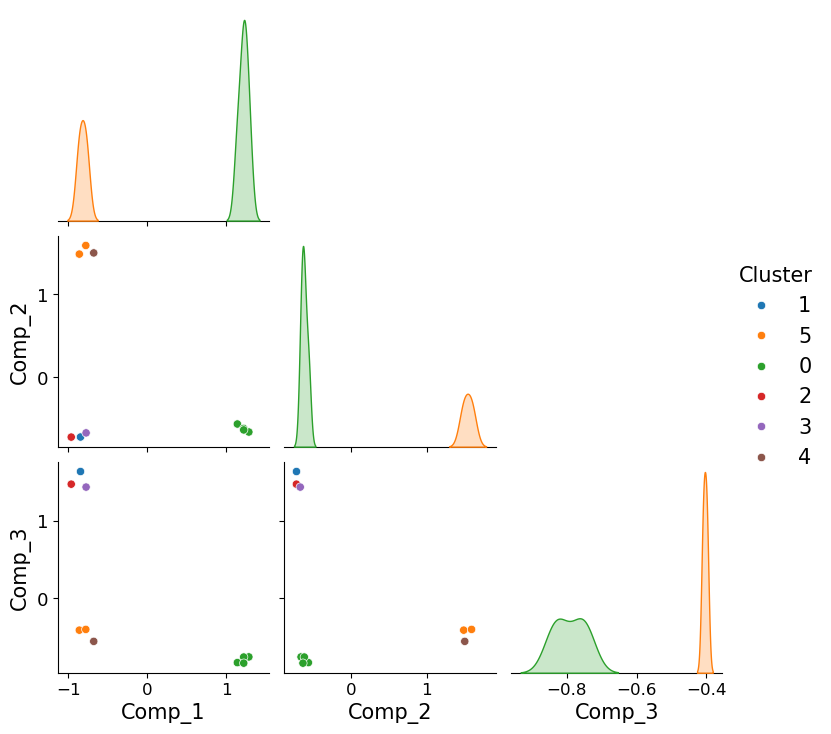

tensor_2 | k: 7 | WCSD: 0.291


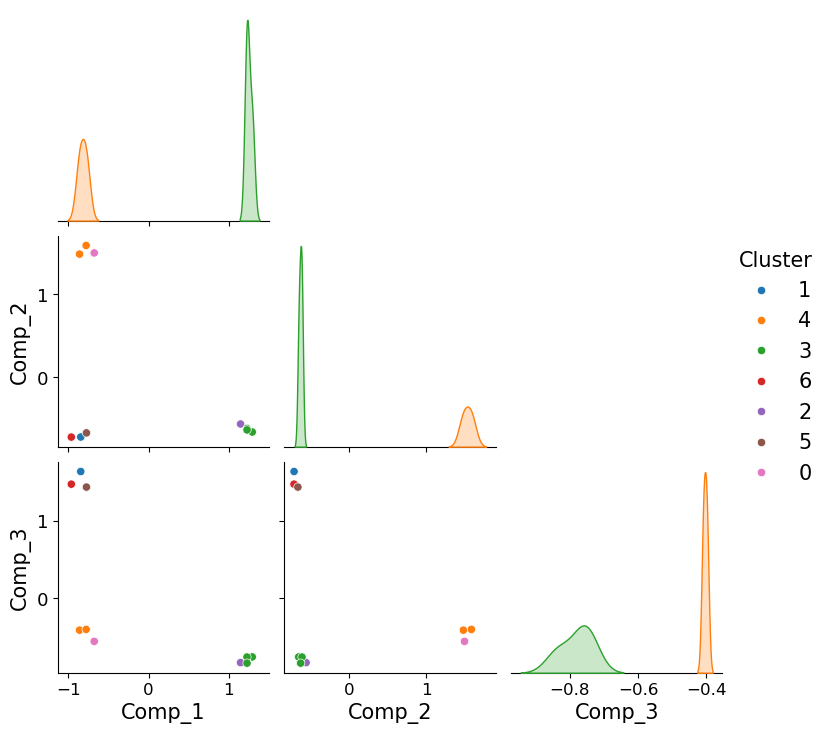

tensor_2 | k: 8 | WCSD: 0.184


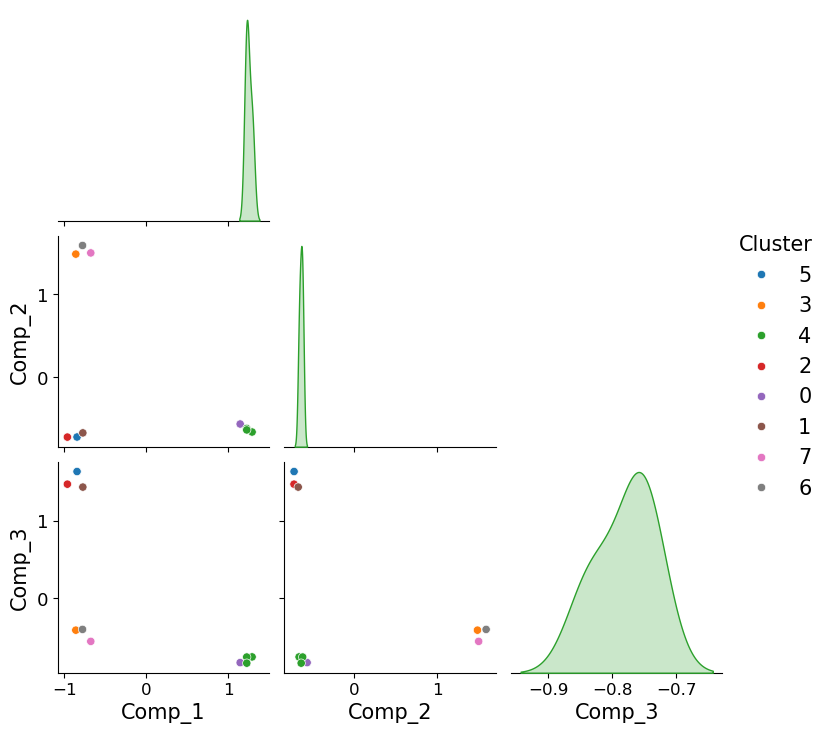

tensor_2 | k: 9 | WCSD: 0.078


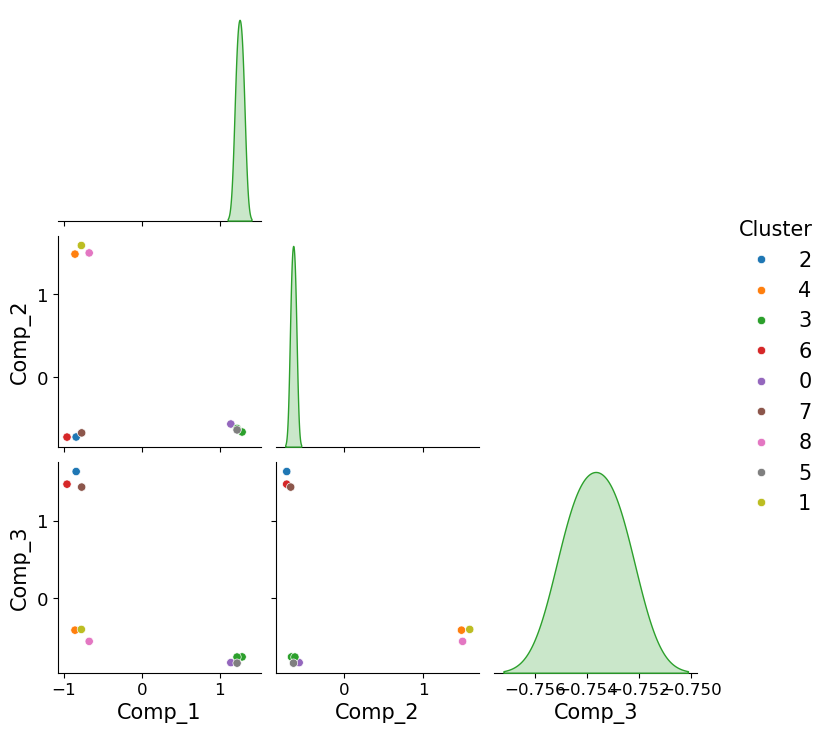

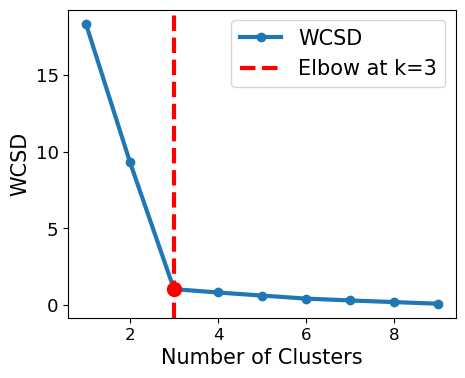

In [61]:
cluster_range = range(1, 10) # Maximum we guess 5 clusters
tensor_key = 'tensor_2'
patient_names = [f'{i}' for i in range(1, 11)]
normalize = True
# normalize=False

kmed_2_results = finding_K(sim_results, tensor_key,cluster_range,patient_names,normalize, foldername='Sim_data')

## All WCSD

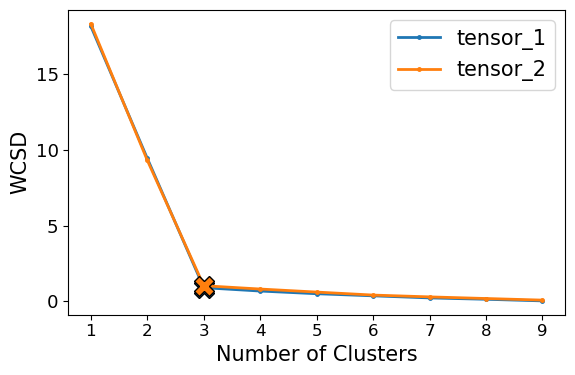

In [62]:
all_results = {
    'tensor_1': kmed_1_results,
    'tensor_2': kmed_2_results
}

plot_all_wcsd(all_results,foldername='Sim_data')

## Component-pair comparison

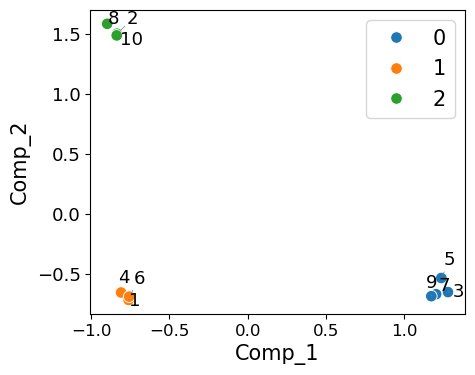

In [63]:
# FOR TENSOR 1
k=3 #Number of clusters we want to plot
result = kmed_1_results[k-1] 
patient_names = [f'{i}' for i in range(1, 11)]

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=1,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='1'
)

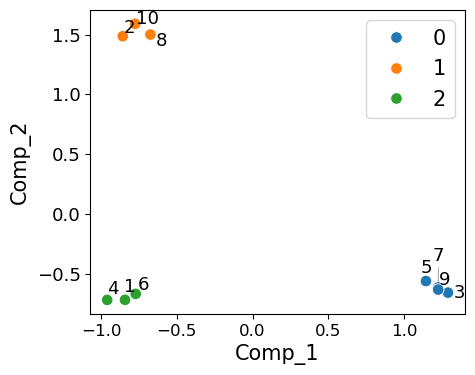

In [64]:
# FOR TENSOR 2
k=3 #Number of clusters we want to plot
result = kmed_2_results[k-1] 
patient_names = [f'{i}' for i in range(1, 11)]

plot_metric_pair_clusters(
    k=result['n_clusters'],
    x_idx=0,
    y_idx=1,
    labels=result['labels'],
    data=result['data_prepared'],
    patient_names=patient_names,
    tensor='2'
)